In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime, timedelta

In [2]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2024-12-31"

try:
    df = yf.download(ticker, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

if df.empty:
    print("No data downloaded. Check the ticker or date range.")
    exit()

if df.isnull().values.any():
    print("There are missing values in the dataframe. Filling missing values with forward fill method.")
    df.fillna(method='ffill', inplace=True)

# Calculate daily log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()  # Remove the first row with NaN

returns = df['Log_Returns']

[*********************100%***********************]  1 of 1 completed


In [3]:
test_size = int(len(returns) * 0.2)
train_data = returns[:-test_size]
test_data = returns[-test_size:]

In [4]:
# Create and fit the GARCH(1,1) model
model = arch_model(train_data, vol='Garch', p=1, q=1)
results = model.fit(update_freq=5) #Update frequency for output during fitting process
print(results.summary())

C:\Users\Lenovo\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -8128.082460832357
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8128.08
Distribution:                  Normal   AIC:                          -16248.2
Method:            Maximum Likelihood   BIC:                          -16224.1
                                        No. Observations:                 3018
Date:                Thu, Jan 02 2025   Df Residuals:                     3017
Time:                        00:21:11   Df Model:                            1
                                 Mean Model                                 
    

C:\Users\Lenovo\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\arch\univariate\base.py:309: D

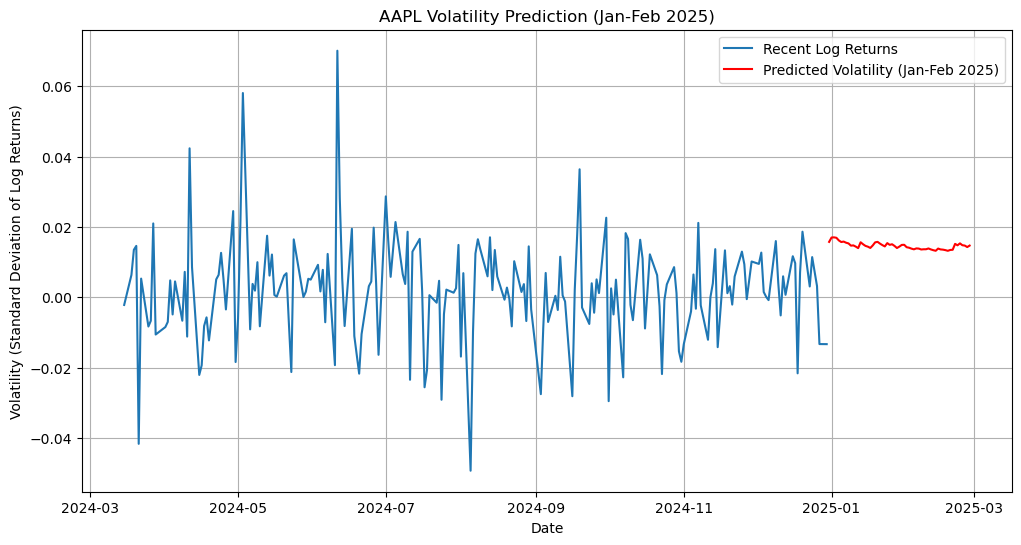

         Date  Predicted Volatility
0  2024-12-31              0.015744
1  2025-01-01              0.016981
2  2025-01-02              0.017028
3  2025-01-03              0.016909
4  2025-01-04              0.016161
5  2025-01-05              0.015700
6  2025-01-06              0.015825
7  2025-01-07              0.015508
8  2025-01-08              0.015305
9  2025-01-09              0.014673
10 2025-01-10              0.014745
11 2025-01-11              0.014399
12 2025-01-12              0.013968
13 2025-01-13              0.015636
14 2025-01-14              0.015073
15 2025-01-15              0.014605
16 2025-01-16              0.014378
17 2025-01-17              0.014016
18 2025-01-18              0.014720
19 2025-01-19              0.015613
20 2025-01-20              0.015749
21 2025-01-21              0.015247
22 2025-01-22              0.014817
23 2025-01-23              0.014454
24 2025-01-24              0.015394
25 2025-01-25              0.014900
26 2025-01-26              0

In [6]:
predictions = []
num_predictions = (31 + 28)  # Number of trading days in Jan-Feb (approx.)
last_date = df.index[-1]
prediction_dates = [last_date + timedelta(days=i+1) for i in range(num_predictions)]
all_predictions = []

for i in range(num_predictions):
    #Refit the model at each step to account for new information
    model = arch_model(returns[:-(num_predictions - i)], vol='Garch', p=1, q=1)
    results = model.fit(update_freq=5, disp='off')
    forecasts = results.forecast(horizon=1)
    forecast_variance = forecasts.variance.values[-1,:][0]
    forecast_std_dev = np.sqrt(forecast_variance)
    all_predictions.append(forecast_std_dev)

#Create a dataframe for predictions
predictions_df = pd.DataFrame({'Date': prediction_dates, 'Predicted Volatility': all_predictions})

# 6. Plot the Volatility Predictions:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Log_Returns'][-200:], label='Recent Log Returns')
plt.plot(predictions_df['Date'], predictions_df['Predicted Volatility'], label='Predicted Volatility (Jan-Feb 2025)', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation of Log Returns)')
plt.title('AAPL Volatility Prediction (Jan-Feb 2025)')
plt.legend()
plt.grid(True)
plt.show()

print(predictions_df)